### 목표
- 타이타닉 데이터를 학습해서 생존자/사망자를 예측해보자
- Decision Tree 모델의 개념을 정립해보자
- 머신러닝 전체과정을 이해해보자

#### 머신러닝 과정
 - 1. 문제정의 : 방향성 설정, 프로젝트 목적 정의, 지도학습 - 분류 vs 회귀 
 - 2. 데이터 수집 : 크롤링, 공공포털사이트 다운, kaggle 다운, db, 설문조사
 - 3. 데이터 전처리 : 정제/ 수정 / 삭제
 - 4. 데이터 탐색(EDA - 탐색적 데이터 분석)
 - 5. 머신러닝 모델 선택 및 하이퍼 파라미터 조정
 - 6. 모델 학습 및 평가

#### 1. 문제정의
 - 생존자 / 사망자 예측
 - Kaggle 경진대회에서 높은 순위 차지해보자
 - 머신러닝 전체 과정을 체험해보는 예제

#### 2. 데이터 수집
 - 데이터 불러와서 확인하기
 - titanic 폴더에 있는 train, test 불러올 것 ( 단, 인덱스는 승객의 아이디로 설정 )

In [451]:
# 환경설정 (도구 불러오기)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # 시각화 라이브러리
import seaborn as sns # 시각화 라이브러리

In [452]:
# index_col = 승객의 아이디 (PassengerId)
train =  pd.read_csv('./data/titanic/train.csv', index_col='PassengerId')
test = pd.read_csv('./data/titanic/test.csv', index_col='PassengerId')
train.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [453]:
test.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [454]:
# 데이터 크기 확인
print('train크기 : ', train.shape)
print('test크기 : ', test.shape)

train크기 :  (891, 11)
test크기 :  (418, 10)


#### 3. 데이터 전처리
 - 데이터 결측치 여부 확인
 - 결측치 처리하는 전처리 진행

In [455]:
train.info() # Survived 없음 -> Kaggle 
# 결측치 - Age, Cabin, Embarked

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [456]:
# 결측치 확인하는 방법(추가)
# isnull() : 결측치가 있으면 True 로 출력하는 함수
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

 - Train : Embarked 결측치 처리 (채우기)

In [457]:
# 결측치를 채울 때 등장 빈도수가 가장 높은 값으로 채워보기 : value_counts()
train['Embarked'].value_counts()
# train.loc[:,'Embarked']
# 데이터를 탐색할 때는 train 데이터 기준으로 확인
# -> 모델이 학습하는 데이터는 train
# -> 일반화에 도움주는 데이터는 train

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [458]:
# 결측치 없애기
train['Embarked'] = train['Embarked'].fillna('S')
train[train['Embarked'].isnull()] # 결측치 처리 확인 코드 1
train['Embarked'].isnull().sum() # 결측치 처리 확인 코드 2

0

 - test : Fare 결측치 처리 (채우기) 

In [459]:
train.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [460]:
# 상관 관계가 있느 변수(컬럼)를 찾아 연결지어 요금값 전처리
# 1. 변수간 상관관계를 확인
# 상관계수 - 상관 관계에 대하여 수치 표현
# -1~1 : -1 , 1 에 가까울 때는 상관이 높음 / 0에 가까울수록 상관이 없음
# corr() : 상관계수 
train.corr()['Fare'].abs().sort_values(ascending = False) # abs() : 절대값
# Pclass -> 승객의 등급

Fare        1.000000
Pclass      0.549500
Survived    0.257307
Parch       0.216225
SibSp       0.159651
Age         0.096067
Name: Fare, dtype: float64

In [461]:
# Fare 요금과 상관이 있는 Pclass 컬럼 확인해보기
train['Pclass'].unique()
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [462]:
# 1등급 승객의 요금
# 2등급 승객의 요금
# 3등급 승객의 요금 그룹화해서 평균값을 확인해보자
# 성별 컬럼 연결시켜 보자
train[['Pclass','Fare','Sex']].groupby(['Pclass','Sex']).mean() # 여러개를 한꺼번에 하고싶으면 대괄호를 추가하면 됨
# mean() : 평균

Fare
Pclass Sex               
1      female  106.125798
       male     67.226127
2      female   21.970121
       male     19.741782
3      female   16.118810
       male     12.661633

In [463]:
# test Fare에 결측치가 있는 행 데이터 출력
# isnull() 사용하여 불리언 인덱싱
test[test['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [464]:
# fillna 사용하여 12.661633 채우기
test['Fare'] = test['Fare'].fillna(12.661633)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


 - train.test : Age 컬럼 처리하기(채우기)

In [465]:
# 단순 기술통계치로 채우지 않고 다른 컬럼과의 상관관계를 이용해 결측치 처리
# Age와 다른 변수(컬럼) 간의 상관관계를 확인
# corr 상관관계(상관계수 출력)
# -1~1 : -1 ,1 에 가까울수록 상관이 높음, 0에 가까울수록 관계성 낮음(상대적)
# 절대값 : abs()
# 정렬함수 안의 ascending 내림, 오름차순 정렬설정값
train.corr()['Age'].abs().sort_values(ascending=False)

Age         1.000000
Pclass      0.369226
SibSp       0.308247
Parch       0.189119
Fare        0.096067
Survived    0.077221
Name: Age, dtype: float64

In [466]:
# Pclass 가장 높은 상관관계를 갖는다
# 생존에 관련이 높을 것 같은 Sex 데이터와 함께 그룹핑 해보자
gb2 = train[['Pclass','Age','Sex']].groupby(['Pclass','Sex']).mean()
gb2

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000
       male    26.507589

In [467]:
train['Age'].isnull().sum() # 결측치 개수 확인
train[train['Age'].isnull()] # 나이가 결측치인 사람들의 데이터 접근

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...
860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S


In [468]:
test['Age'].isnull().sum() # 86 결측치 있음
test[test['Age'].isnull()] # 나이가 결측치인 사람들의 데이터 접근

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
902,3,"Ilieff, Mr. Ylio",male,NaN,0,0,349220,7.8958,NaN,S
914,1,"Flegenheim, Mrs. Alfred (Antoinette)",female,NaN,0,0,PC 17598,31.6833,NaN,S
921,3,"Samaan, Mr. Elias",male,NaN,2,0,2662,21.6792,NaN,C
925,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
928,3,"Roth, Miss. Sarah A",female,NaN,0,0,342712,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1300,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q
1302,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S


In [469]:
# 1. 'male' 에 접근
gb2.loc[(1,'male')]

Age    41.281386
Name: (1, male), dtype: float64

In [470]:
# 3. 'female'에 접근
gb2.loc[(3,'female')]

Age    21.75
Name: (3, female), dtype: float64

In [471]:
# 넘파이 isnan 함수 - 결측치가 있는지 확인하는 함수
# np = numpy 라이브러리
temp = np.array([1,2,np.nan])
np.isnan(temp)

array([False, False,  True])

apply : 판다스 객체에 더 복잡한 처리를 적용할 때 사용하는 함수

In [472]:
# 1. 사용자 정의 함수 : 복잡한 나이 처리
# 2. 데이터와 함수 연결 : apply
def fill_age(row): # row 매개변수명 -> 데이터를 행단위로 처리
    # row 데이터에서 Age 컬럼값을 확인하고 결측치면 조건문 안으로
    if np.isnan(row['Age']): # isnan() :  매개변수가 숫자인지 판단하는 메서드
        age_mean = gb2.loc[(row['Pclass'],row['Sex'])]
        return age_mean
    # 아닐 경우에는 기존 값 그대로 반환
    else :
        return row['Age']

In [473]:
# 2 데이터와 함수 연결 : apply
# axis 축설정 axis = 0 행방향(열단위 처리), axis = 1 열방향(행단위 처리)
train['Age'] = train.apply(fill_age, axis =1 ).astype('int64')
train['Age'].isnull().sum() # 결측치 없음 ! 처리완료

0

In [474]:
train[train['Age'].isnull()] #처리완료

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,


In [475]:
# test 결측치 처리 -> 저장
test['Age'] = test.apply(fill_age, axis=1).astype('int64')
test['Age'].isnull().sum() # 결측치 없음 - 처리완료

0

 - train,test : Cabin 결측치 처리(채우기)

In [476]:
# Cabin 값 확인하기
# 중복없이 값 확인
train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [477]:
# fillna('M')
train['Cabin'] = train['Cabin'].fillna('M')
test['Cabin'] = test['Cabin'].fillna('M')
train['Cabin'].isnull().sum(), test['Cabin'].isnull().sum()

(0, 0)

In [478]:
# 문자열 접근하는 키워드 : str
# Cabin 맨 앞글자 알파벳 한개 인덱싱
train['Cabin'] = train['Cabin'].str[0]
test['Cabin'] = test['Cabin'].str[0]
test['Cabin']

PassengerId
892     M
893     M
894     M
895     M
896     M
       ..
1305    M
1306    C
1307    M
1308    M
1309    M
Name: Cabin, Length: 418, dtype: object

#### 4. 데이터 탐색
 - train 데이터를 이용해 탐색 -> 학습이용 데이터 기준으로 살펴야함
 - test를 살피는 것은 일반화에 도움줄 수 없음


#### 범주형 시각화
 - Cabin 시각화

In [479]:
# M, C, A 각각 몇개씩 들어가 있는지 확인
train_cb = train[['Cabin','Survived','Name']].groupby(['Cabin','Survived']).count()
train_cb

Name
Cabin Survived      
A     0            8
      1            7
B     0           12
      1           35
C     0           24
      1           35
D     0            8
      1           25
E     0            8
      1           24
F     0            5
      1            8
G     0            2
      1            2
M     0          481
      1          206
T     0            1

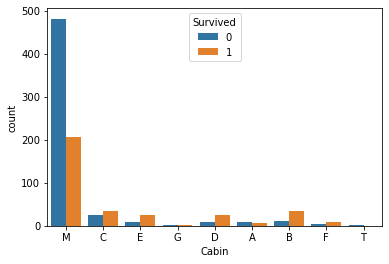

In [480]:
sns.countplot(data=train, x= 'Cabin', hue='Survived')
plt.show()

- Plcass 시각화

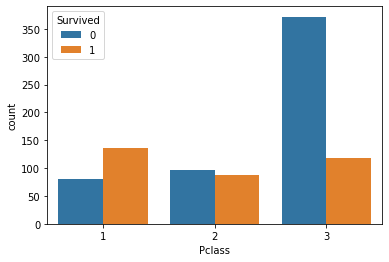

In [481]:
# 승객의 등급에 따른 생존/사망 시각화
sns.countplot(data = train, x = 'Pclass', hue = 'Survived')
plt.show() # 그래프 자체만 출력
# 3등급의 사람들은 상대적으로 사망율이 높음
# sns = seaborn 라이브러리
# x = x축 // hue = 면적 

- Pclass, Cabin 시각화

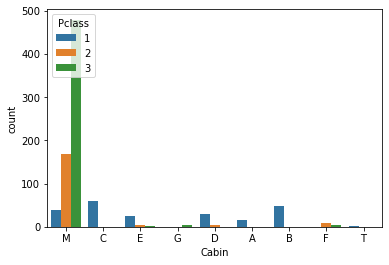

In [482]:
sns.countplot(data=train, x ='Cabin', hue='Pclass')
plt.show()

# M등급에서 사람이 많이 죽은 이유는 단순히 3등급의 사람들이 많았기 때문
# Cabin 자체가 생존/사망에 크게 영향을 주지는 않음

 - Sex 시각화
  성별에 따른 생존/사망 시각화

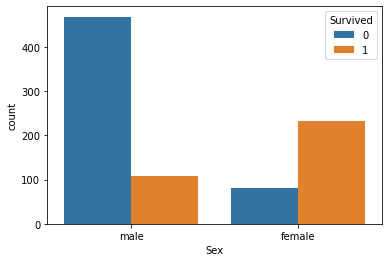

In [483]:
sns.countplot(data=train, x='Sex', hue='Survived')
plt.show()

- Embarked 시각화
 승선항에 따른 생존/사망 시각화

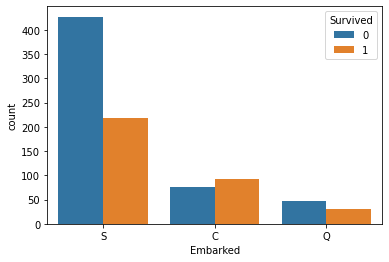

In [484]:
sns.countplot(data=train, x='Embarked', hue='Survived')
plt.show()

#### 수치형 시각화
- Age 시각화

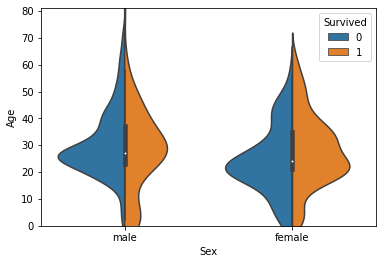

In [485]:
# 바이올린 플롯(violin plot) : 데이터의 분포를 확인할 때 사용하는 그래프
# 나이에 따른 생존 / 사망 시각화 + 성별분리
sns.violinplot(data = train,
              x = 'Sex',
              y = 'Age',
              hue = 'Survived',
              split=True)
plt.ylim(0,81)
plt.show()

# 어린아이 중에서는 남자아이가 여자아이에 비해 생존율이 높음
# 20대 ~ 30대 사이가 많이 사망했음

In [486]:
train['Age'].describe()

count    891.000000
mean      29.191919
std       13.313598
min        0.000000
25%       21.000000
50%       26.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64

- Fare 시각화

In [487]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

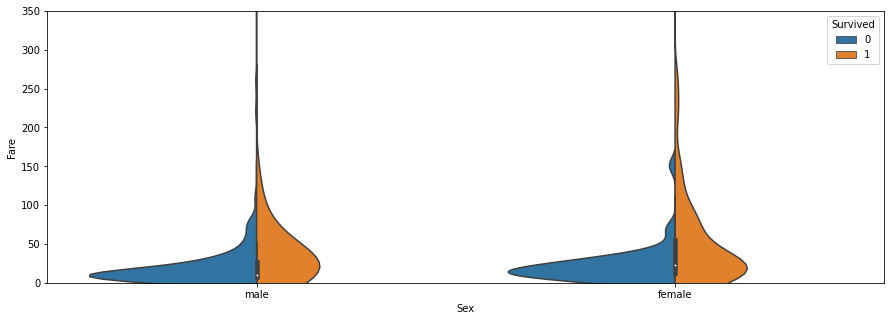

In [488]:
plt.figure(figsize=(15,5))
sns.violinplot(data=train,
              x='Sex',
              y='Fare',
              hue='Survived',
              split=True
              )
plt.ylim(0,350)
plt.show()

# 요금이 싼사람은 상대적으로 사망율이 높음

#### 특성공학 :특성추출
 - 기존의 가지고 있던 컬럼을 통해 새로운 컬럼을 만들어 내는 것
 - 가족의 수라는 컬럼 생성
 - Parch, SibSp 컬럼 활용

In [489]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [490]:
# Family_Size
train['Family_Size'] = train['Parch']+train['SibSp']+1 # 배열끼리 연산해줌 ( + )
test['Family_Size'] = test['Parch']+test['SibSp']+1

train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          891 non-null    int64  
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        891 non-null    object 
 10  Embarked     891 non-null    object 
 11  Family_Size  891 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 90.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       418 non-null    int64  
 1   Name 

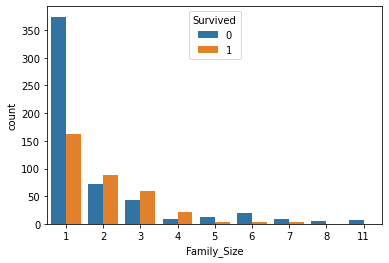

In [491]:
# 가족의 수에 따른 생존/사망 시각화
sns.countplot(data=train, x ='Family_Size', hue = 'Survived')
plt.show()

# 1명일 때는 사망율이 높고, 2~4일때는 생존율이 높고 , 5~ 사망율이 높음
# binning -> 범위를 줄여주는 것 -> 사소한 관찰의 오류의 영향을 줄일 수 있음

- 가족의 수가 1이면 'Alone', 2~4명이면 'Small', 5명이상이면 'Large'
- train.test 모두 적용

In [492]:
# cut 함수 : 카테고리와 시키는 함수 
bins = [0,1,4,11]
labels = ['Alone','Small','Large']
train['Family_Group']=pd.cut(train['Family_Size'], bins=bins, labels = labels)
train['Family_Group']

test['Family_Group']=pd.cut(test['Family_Size'], bins=bins, labels = labels)
test['Family_Group']

PassengerId
892     Alone
893     Small
894     Alone
895     Alone
896     Small
        ...  
1305    Alone
1306    Alone
1307    Alone
1308    Alone
1309    Small
Name: Family_Group, Length: 418, dtype: category
Categories (3, object): ['Alone' < 'Small' < 'Large']

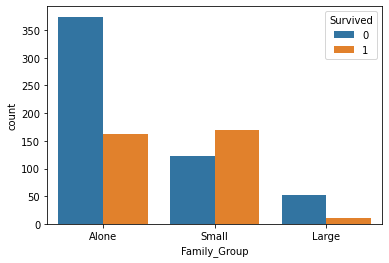

In [493]:
# 시각화
sns.countplot(data=train, x ='Family_Group', hue = 'Survived')
plt.show()

- Name 컬럼에서 중요한 호칭을 추출해보자 mr,mrs,master ..

In [494]:
# train - name 컬럼 접근 -> 1번째 승객 이름만 접근
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Family_Size', 'Family_Group'],
      dtype='object')

In [495]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      891 non-null    int64   
 1   Pclass        891 non-null    int64   
 2   Name          891 non-null    object  
 3   Sex           891 non-null    object  
 4   Age           891 non-null    int64   
 5   SibSp         891 non-null    int64   
 6   Parch         891 non-null    int64   
 7   Ticket        891 non-null    object  
 8   Fare          891 non-null    float64 
 9   Cabin         891 non-null    object  
 10  Embarked      891 non-null    object  
 11  Family_Size   891 non-null    int64   
 12  Family_Group  891 non-null    category
dtypes: category(1), float64(1), int64(6), object(5)
memory usage: 91.5+ KB


In [496]:
train['Name'][1]

'Braund, Mr. Owen Harris'

In [497]:
# 호칭만 추출해보자 -> 슬라이싱 , split 함수 쓰기
# str -> pandas 객체 내 문자에 접근 (한꺼번에 접근하는 문자열) 구분할것
# strip() -> 양쪽 공백 없애기 
train['Name'][1].split(".")[0].split(",")[1].strip()

'Mr'

In [498]:
# apply 적용하여 Name 컬럼에 있는 호칭 추출하기
# 1. 사용자가 함수 정의
def split_title(row): # row = train['Name'][1]
    return row.split(".")[0].split(",")[1].strip()

In [499]:
train['Title'] = train['Name'].apply(split_title)
train['Title']

PassengerId
1        Mr
2       Mrs
3      Miss
4       Mrs
5        Mr
       ... 
887     Rev
888    Miss
889    Miss
890      Mr
891      Mr
Name: Title, Length: 891, dtype: object

In [500]:
# test Title 컬럼 생성해보기
test['Title'] = test['Name'].apply(split_title)
test['Title']

PassengerId
892         Mr
893        Mrs
894         Mr
895         Mr
896        Mrs
         ...  
1305        Mr
1306      Dona
1307        Mr
1308        Mr
1309    Master
Name: Title, Length: 418, dtype: object

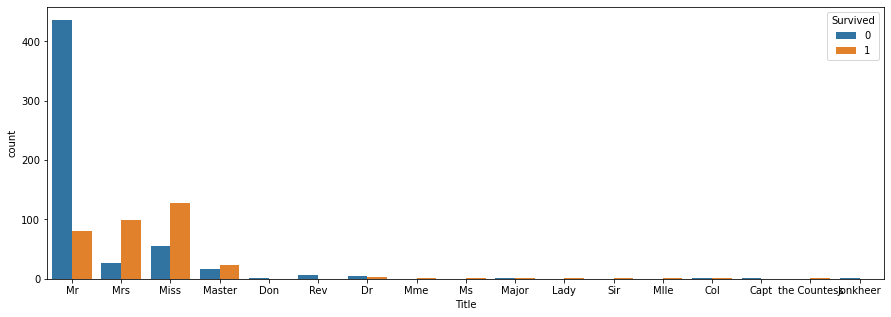

In [501]:
# 호칭 컬럼 시각화
# 호칭에 따른 생존 / 사망 비율 시각화 
plt.figure(figsize = (15,5)) # import matplotlib
sns.countplot(data = train, x = 'Title', hue = 'Survived') # seaborn 차트
plt.show()

In [502]:
train['Title'].unique() # 중복없이 

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [503]:
title = ['Mr', 'Mrs', 'Miss', 'Master', 'Rev',
         'Don','Dr', 'Mme', 'Ms','Major', 'Lady', 'Sir',
         'Mlle', 'Col', 'Capt', 'the Countess','Jonkheer']
print(len(title))

# other = Don 부터 ~ Jonkheer 까지
convert_title = ['Mr', 'Mrs', 'Miss', 'Master', 'Rev'] + ['Other'] * 12
convert_title
print(len(convert_title))

# 딕셔너리로 생성 # zip : 데이터 엮기
title_dict = dict(zip(title, convert_title))
title_dict

17
17


{'Mr': 'Mr',
 'Mrs': 'Mrs',
 'Miss': 'Miss',
 'Master': 'Master',
 'Rev': 'Rev',
 'Don': 'Other',
 'Dr': 'Other',
 'Mme': 'Other',
 'Ms': 'Other',
 'Major': 'Other',
 'Lady': 'Other',
 'Sir': 'Other',
 'Mlle': 'Other',
 'Col': 'Other',
 'Capt': 'Other',
 'the Countess': 'Other',
 'Jonkheer': 'Other'}

In [504]:
# map 함수를 통해서 실제 데이터에 적용해보기
# map은 원본 리스트를 변경하지 않고 새 리스트를 생성
train['Title']=train['Title'].map(title_dict)
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other', 'Rev'], dtype=object)

In [505]:
test['Title'].unique() # train에는 Don이 있는데 test에는 Dona임 그래서 추가해줘야함

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [506]:
# title_dict 딕셔너리 값 추가 
# Dona -> Other
title_dict['Dona'] = 'Other'
title_dict

# test 호칭 정리 코드 적용
test['Title'] = test['Title'].map(title_dict)
test['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other', 'Rev'], dtype=object)

- 불필요한 컬럼 삭제


In [507]:
train.info() # Name , Ticket , Family_Size 를 삭제
# drop
# 여러개를 한번에 삭제하고 싶으면 [] 대괄호를 씀
train.drop(['Name','Ticket','Family_Size'], axis = 1, inplace = True)
test.drop(['Name','Ticket','Family_Size'], axis = 1, inplace = True)
# 2번 실행하면 에러 뜸 이유 : 이미 지운 컬럼을 한번 더 삭제하기 때문에 (inplace)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      891 non-null    int64   
 1   Pclass        891 non-null    int64   
 2   Name          891 non-null    object  
 3   Sex           891 non-null    object  
 4   Age           891 non-null    int64   
 5   SibSp         891 non-null    int64   
 6   Parch         891 non-null    int64   
 7   Ticket        891 non-null    object  
 8   Fare          891 non-null    float64 
 9   Cabin         891 non-null    object  
 10  Embarked      891 non-null    object  
 11  Family_Size   891 non-null    int64   
 12  Family_Group  891 non-null    category
 13  Title         891 non-null    object  
dtypes: category(1), float64(1), int64(6), object(6)
memory usage: 130.7+ KB


In [508]:
train.info() # 11 개
test.info() # 10 개

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      891 non-null    int64   
 1   Pclass        891 non-null    int64   
 2   Sex           891 non-null    object  
 3   Age           891 non-null    int64   
 4   SibSp         891 non-null    int64   
 5   Parch         891 non-null    int64   
 6   Fare          891 non-null    float64 
 7   Cabin         891 non-null    object  
 8   Embarked      891 non-null    object  
 9   Family_Group  891 non-null    category
 10  Title         891 non-null    object  
dtypes: category(1), float64(1), int64(5), object(4)
memory usage: 109.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Pclass        418 non-null    int64   
 1   S

- 문제와 답으로 분리

In [509]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family_Group,Title
PassengerId,,,,,,,,,,,
1,0,3,male,22,1,0,7.2500,M,S,Small,Mr
2,1,1,female,38,1,0,71.2833,C,C,Small,Mrs
3,1,3,female,26,0,0,7.9250,M,S,Alone,Miss
4,1,1,female,35,1,0,53.1000,C,S,Small,Mrs
5,0,3,male,35,0,0,8.0500,M,S,Alone,Mr


In [510]:
X_train = train.drop('Survived', axis = 1) # 훈련용 문제 Survived 를 제외한 모든 컬럼
y_train = train['Survived'] # 훈련용 답 Surviced
X_test = test # 테스트용 문제

print('훈련문제 : ', X_train.shape)
print("훈련 답 : ", y_train.shape)
print('테스트문제 : ', X_test.shape)

훈련문제 :  (891, 10)
훈련 답 :  (891,)
테스트문제 :  (418, 10)


 - 특성 인코딩 (문자 -> 수치화)
 - 원핫 인코딩 - 수치값 크고 작음의 의미가 없을 때
 - 레이블 인코딩 - 수치값이 크고 작음의 의미가 있을 때


In [511]:
feature_cat = ['Sex','Cabin','Embarked','Family_Group','Title']

for cat in feature_cat :
    dum = pd.get_dummies(X_train[cat], prefix=cat)
    # 변경된 더미 변수들을 X_train에 병합하기
    X_train = pd.concat([X_train,dum], axis = 1)
    # 기존 문자로된 컬럼은 삭제
    X_train.drop(cat, axis = 1 ,inplace = True)
    
# pd.get_dummies(대상)

In [512]:
X_train.head(2)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,...,Embarked_S,Family_Group_Alone,Family_Group_Small,Family_Group_Large,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Title_Rev
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,3,22,1,0,7.2500,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,1,38,1,0,71.2833,1,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0


In [513]:
# X_test 인코딩 적용해보기!

for cat in feature_cat :
    dum = pd.get_dummies(X_test[cat], prefix=cat)
    # 변경된 더미 변수들을 X_train에 병합하기
    X_test = pd.concat([X_test,dum], axis = 1)
    # 기존 문자로된 컬럼은 삭제
    X_test.drop(cat, axis = 1 ,inplace = True)

    # 오류뜨면 drop 때문에 이미 삭제했는데 한번 더 실행해서 그럼

In [514]:
# 크기 확인
print('훈련용문제 : ', X_train.shape)
print('테스트용 문제 :', X_test.shape)

훈련용문제 :  (891, 28)
테스트용 문제 : (418, 27)


In [515]:
X_test.head(2)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,...,Embarked_S,Family_Group_Alone,Family_Group_Small,Family_Group_Large,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Title_Rev
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,3,34,0,0,7.8292,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
893,3,47,1,0,7.0000,1,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0


In [518]:
# Deck_T
# set() 집합 - 중복없음
set(X_train.columns) - set(X_test.columns)

{'Cabin_T'}

In [519]:
# test에 새로운 컬럼 추가
# 데이터 전체 다 0
X_test['Cabin_T'] = 0
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pclass              418 non-null    int64  
 1   Age                 418 non-null    int64  
 2   SibSp               418 non-null    int64  
 3   Parch               418 non-null    int64  
 4   Fare                418 non-null    float64
 5   Sex_female          418 non-null    uint8  
 6   Sex_male            418 non-null    uint8  
 7   Cabin_A             418 non-null    uint8  
 8   Cabin_B             418 non-null    uint8  
 9   Cabin_C             418 non-null    uint8  
 10  Cabin_D             418 non-null    uint8  
 11  Cabin_E             418 non-null    uint8  
 12  Cabin_F             418 non-null    uint8  
 13  Cabin_G             418 non-null    uint8  
 14  Cabin_M             418 non-null    uint8  
 15  Embarked_C          418 non-null    uint8  
 16  Embar

In [566]:
# 학습하는 데이타의 특정 순서에 맞춰서
# 테스트하는 데이터도 맞춰줘야함
X_test = X_test[X_train.columns] # 불리언 인덱싱 아님 단순히 X_test에서 컬럼의 정보를 알고 싶어서 한거임

In [567]:
X_test

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,...,Embarked_S,Family_Group_Alone,Family_Group_Small,Family_Group_Large,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Title_Rev
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,3,34,0,0,7.8292,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
893,3,47,1,0,7.0000,1,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
894,2,62,0,0,9.6875,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
895,3,27,0,0,8.6625,0,1,0,0,0,...,1,1,0,0,0,0,1,0,0,0
896,3,22,1,1,12.2875,1,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3,26,0,0,8.0500,0,1,0,0,0,...,1,1,0,0,0,0,1,0,0,0
1306,1,39,0,0,108.9000,1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
1307,3,38,0,0,7.2500,0,1,0,0,0,...,1,1,0,0,0,0,1,0,0,0


In [524]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pclass              891 non-null    int64  
 1   Age                 891 non-null    int64  
 2   SibSp               891 non-null    int64  
 3   Parch               891 non-null    int64  
 4   Fare                891 non-null    float64
 5   Sex_female          891 non-null    uint8  
 6   Sex_male            891 non-null    uint8  
 7   Cabin_A             891 non-null    uint8  
 8   Cabin_B             891 non-null    uint8  
 9   Cabin_C             891 non-null    uint8  
 10  Cabin_D             891 non-null    uint8  
 11  Cabin_E             891 non-null    uint8  
 12  Cabin_F             891 non-null    uint8  
 13  Cabin_G             891 non-null    uint8  
 14  Cabin_M             891 non-null    uint8  
 15  Cabin_T             891 non-null    uint8  
 16  Embarked

### 5. 모델링
- 모델 선택 및 하이퍼 파라미터 조정
- 모델 학습
- 모델 예측 및 평가
- knn, decisiontree 모두 적용해보기

In [525]:
from sklearn.neighbors import KNeighborsClassifier # 최근접 이웃 알고리즘
from sklearn.tree import DecisionTreeClassifier # 의사결정 나무 모델
# 일반화정도는 어떻게 될까 ? -> 교차검증
from sklearn.model_selection import cross_val_score

- Tree 모델

In [533]:
# 객체 생성
tree_model = DecisionTreeClassifier(max_depth=3)

In [534]:
# 교차 검증 -> train 데이터 기준으로 실행
# 총 5번 실행해보기
# 결과 result 변수에 담기 
result = cross_val_score(tree_model, X_train, y_train, cv=5) # cv : 교차검증 횟수
print('교차검증 결과: ',result)
print('교차검증 결과평균: ',result.mean())

교차검증 결과:  [0.82681564 0.79213483 0.8258427  0.78651685 0.84831461]
교차검증 결과평균:  0.8159249262444291


- knn 모델

In [536]:
knn_model = KNeighborsClassifier(n_neighbors=3) # shift + tab 누르면 정보 볼 수 있음
# 교차검증
# 횟수 5번
knn_result = cross_val_score(knn_model, X_train, y_train, cv =5)
print('교차검증 결과: ',knn_result)
print('교차검증 결과평균: ',knn_result.mean())

교차검증 결과:  [0.69832402 0.68539326 0.7247191  0.75842697 0.74157303]
교차검증 결과평균:  0.7216872763793861


In [537]:
# 거리 계싼에 민감한 knn 모델의 성능을 높이기 위해
# 데이터의 규모를 정리해보자 -> Scale
# sklearn 에서 Scaler 를 제공해줌

from sklearn.preprocessing import StandardScaler

In [539]:
# 스케일러 생성
sc = StandardScaler()
# 데이터 확인시키기 => fit() : 학습시키기
sc.fit(X_train) 

StandardScaler()

In [542]:
# 스케일 변환을 진행
# transform
X_train_ft = sc.transform(X_train)
X_train_ft

X_test_ft = sc.transform(X_test)
X_test_ft

array([[ 0.82737724,  0.36134344, -0.4745452 , ..., -0.4039621 ,
        -0.15536387, -0.0823387 ],
       [ 0.82737724,  1.33833714,  0.43279337, ...,  2.47547975,
        -0.15536387, -0.0823387 ],
       [-0.36936484,  2.46563756, -0.4745452 , ..., -0.4039621 ,
        -0.15536387, -0.0823387 ],
       ...,
       [ 0.82737724,  0.66195688, -0.4745452 , ..., -0.4039621 ,
        -0.15536387, -0.0823387 ],
       [ 0.82737724, -0.23988346, -0.4745452 , ..., -0.4039621 ,
        -0.15536387, -0.0823387 ],
       [ 0.82737724, -0.23988346,  0.43279337, ..., -0.4039621 ,
        -0.15536387, -0.0823387 ]])

In [556]:
# knn 모델 교차검증 2
result_knn = cross_val_score(knn_model, X_train_ft, y_train, cv = 5)
print('결과 : ', result_knn)
print('정확도 평균 결과 : ', result_knn.mean())

결과 :  [0.79888268 0.74719101 0.80337079 0.76966292 0.83146067]
정확도 평균 결과 :  0.7901136149645346


In [557]:
X_test.head(2)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,...,Embarked_S,Family_Group_Alone,Family_Group_Small,Family_Group_Large,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Title_Rev
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,3,34,0,0,7.8292,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
893,3,47,1,0,7.0000,1,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0


- tree model 학습, 예측 , 평가

In [555]:
# 학습 : fit(훈련용 문제, 훈련용 답)
tree_model.fit(X_train, y_train)
# 예측 : predict(테스트 문제)
tree_pre =  tree_model.predict(X_test)
tree_pre

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [564]:
# 평가 -> kaggle 업로드
submission = pd.read_csv('data/titanic/gender_submission.csv')
submission['Survived'] = tree_pre # 답안지 초기화 
submission.to_csv('data/titanic/ljy_submission01.csv', index = False) # csv로 저장

In [565]:
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


- 76% 정확도를 가지고 있음
- 모델의 성능을 개선시키고 싶으면 1. 과대적합을 제어할 것 2. 데이터를 수정(변경), 추가(특성공학) 3. 여러모델을 사용해보기 